In [2]:
'''
Full optimisation process in a single file
'''

# required libraries
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import openpyxl
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance, base_optimizer

In [ ]:
'''
Get stock prices from an API using symbol input, or return previous prices. 
'''

def fetch_and_save_data():
    '''
    Combines user input handling and data fetching into a single function.
    If symbols are provided in a CSV, pulls data from Tiingo API, otherwise returns prices from a provided CSV.
    '''
    user_input = input("Have you entered symbols into a CSV file? (Y/N): ").strip().lower()
    if user_input in ['y', 'yes']:
        try:
            # Load symbols, start date, and end date from CSV
            df = pd.read_csv('symbols.csv')

            # Check if required columns are present
            required_columns = ['symbol', 'start_date', 'end_date']
            df.columns = df.columns.str.lower() # ignore case
            for col in required_columns:
                if col not in df.columns:
                    raise KeyError(f"The CSV file must contain a column named '{col}'.")

            symbols = df['symbol'].dropna().tolist()
            start_date = df['start_date'].dropna().iloc[0]
            end_date = df['end_date'].dropna().iloc[0]

            # Validate that start_date and end_date are provided
            if not start_date or not end_date:
                raise ValueError("Start date and end date must be provided in the CSV file.")

            # Load the API key from the .env file
            load_dotenv()
            API_KEY = os.getenv('Tiingo')

            if not API_KEY:
                raise ValueError("API key not found in env file.")
            
            # API EOD URL from Tiingo
            url = 'https://api.tiingo.com/tiingo/daily/{symbol}/prices'

            # Function to fetch EOD data for a single symbol
            def get_eod_data(symbol, start_date, end_date, api_key):
                # Define parameters for the API request
                headers = {
                    'Content-Type': 'application/json',
                    'Authorization': f'Token {api_key}'
                }
                querystring = {
                    'startDate': start_date,
                    'endDate': end_date
                }

                # Make the request
                response = requests.get(url.format(symbol=symbol), headers=headers, params=querystring)

                # Check if all data has been received, error reporting
                if response.status_code == 200:
                    data = response.json()
                    if not data:
                        return pd.DataFrame()  # Return empty DataFrame if no data available

                    df = pd.DataFrame(data)
                    df['symbol'] = symbol  # Add a column for the symbol
                    return df
                else:
                    print(f"Error: {response.status_code}, {response.text}")
                    return pd.DataFrame()

            # Initialise an empty DataFrame to store all the data
            price_df = pd.DataFrame()

            # Loop through each symbol and fetch price data
            for symbol in symbols:
                symbol_df = get_eod_data(symbol, start_date, end_date, API_KEY)
                price_df = pd.concat([price_df, symbol_df], ignore_index=True)

            # Check if the data is non-empty before proceeding. 
            if not price_df.empty:
                # Format the date
                price_df = price_df[['date', 'adjClose', 'symbol']]
                price_df['date'] = pd.to_datetime(price_df['date']).dt.date

                # Pivot to get symbols in columns and dates as index
                price_df = price_df.pivot(index='date', columns='symbol', values='adjClose')

                # print(price_df.head())

                # Save to CSV
                price_df.to_csv('prices.csv', index=True)
                return 'prices.csv'
            else:
                print("No data available")
                return None
        except KeyError as e:
            raise KeyError(str(e))
        except FileNotFoundError:
            raise FileNotFoundError("The file 'symbols.csv' was not found.")
        except ValueError as e:
            print(e)
            return None
    
    user_input = input("Have you provided a list of symbols and prices in a CSV format? (Y/N): ").strip().lower()
    if user_input in ['y', 'yes']:
        try:
            prices = pd.read_csv('prices.csv')
            # print(prices.head())
            return 'prices.csv'
        except FileNotFoundError:
            raise FileNotFoundError("The file 'prices.csv' was not found. Please ensure it is in the correct directory.")
    
    return None


result = fetch_and_save_data()
if result:
    print(f"Data saved to {result}")




Data saved to prices.csv


AAPL    0.338744
AMZN    0.165084
GOOG    0.224226
META    0.263814
MSFT    0.265094
NVDA    0.947882
UNH     0.236904
dtype: float64
                AAPL      AMZN      GOOG      META      MSFT      NVDA  \
date                                                                     
2019-10-31  0.110684  0.023475  0.033724  0.076202  0.031216  0.154823   
2019-11-30  0.077517  0.013587  0.035592  0.052126  0.059469  0.078992   
2019-12-31  0.098784  0.026122  0.024568  0.017903  0.041749  0.085633   
2020-01-31  0.054010  0.087064  0.072706 -0.016273  0.079455  0.004802   
2020-02-29 -0.114673 -0.062214 -0.066168 -0.046754 -0.045696  0.143007   

                 UNH  
date                  
2019-10-31  0.162801  
2019-11-30  0.107519  
2019-12-31  0.054465  
2020-01-31 -0.073236  
2020-02-29 -0.064195  
      AAPL  AMZN  GOOG  META  MSFT  NVDA   UNH
AAPL  1.00  0.68  0.54  0.40  0.69  0.54  0.40
AMZN  0.68  1.00  0.64  0.48  0.68  0.63  0.14
GOOG  0.54  0.64  1.00  0.46  0.68  0.57  0.2

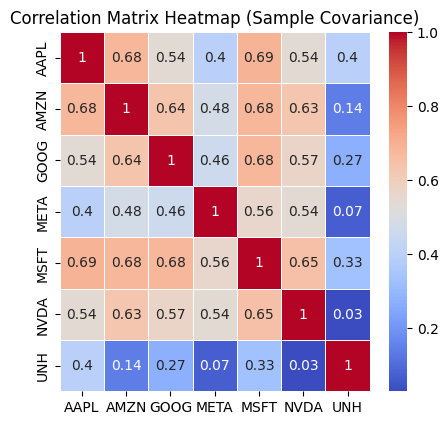

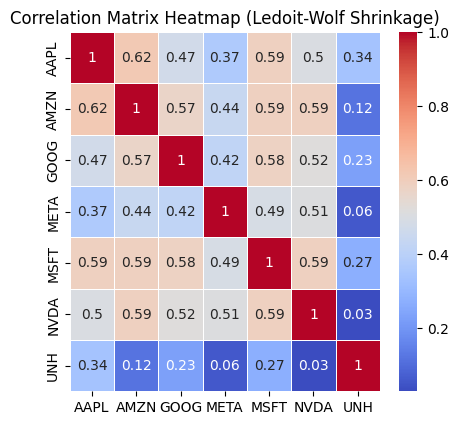

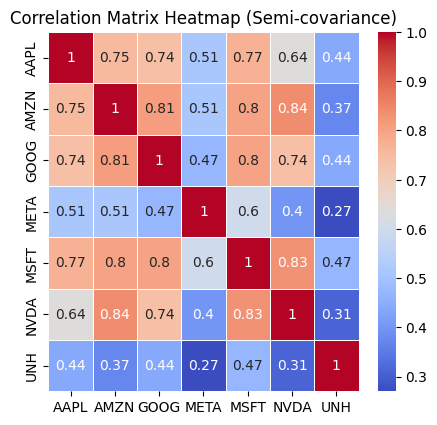

In [ ]:
'''
Generate covariance/semicovariance matrices and correlations.
'''

# Load prices
prices = pd.read_csv('prices.csv')
prices.set_index('date', inplace=True)
prices.index = pd.to_datetime(prices.index)

# Calculate monthly prices, returns and expected returns 
monthly_prices = prices.resample('ME').last()  # Resample to get monthly prices
monthly_returns = monthly_prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(monthly_prices, frequency=12)
print(mu)
print(monthly_returns.head())

# Calculate covariance matrices
cov_sample = risk_models.sample_cov(monthly_prices, frequency=12) # inclusion in output only. Easy to understand method
cov_ledoit = risk_models.CovarianceShrinkage(monthly_prices, frequency=12).ledoit_wolf()
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=0.0, frequency=12)

# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)
    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    # Round output to 2dp
    corr_matrix = corr_matrix.round(2)

    return corr_matrix

corr_sample = calculate_correlation(cov_sample)
corr_ledoit = calculate_correlation(cov_ledoit)
corr_semicov = calculate_correlation(semivarcov)
print(corr_sample.head())

# # Plotting the correlation matrices as heatmaps
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_sample, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Sample Covariance)')
# plt.show()
# plt.savefig('correlation_heatmap.png')

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
# plt.show()
# plt.savefig('correlation_heatmap_ledoit.png')

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_semicov, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Semi-covariance)')
# plt.show()
# plt.savefig('correlation_heatmap_semivar.png')

# Reorganised heatmap generation as a function, dynamic sizing
def plot_correlation_heatmap(corr_matrix, title, filename):
    plt.figure(figsize=((len(corr_matrix) / 1.4), (len(corr_matrix) / 1.5)) )
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Matrix Heatmap ({title})')
    plt.savefig(filename)
    plt.show()

plot_correlation_heatmap(corr_sample, 'Sample Covariance', 'correlation_heatmap_sample.png')
plot_correlation_heatmap(corr_ledoit, 'Ledoit-Wolf Shrinkage', 'correlation_heatmap_ledoit.png')
plot_correlation_heatmap(corr_semicov, 'Semi-covariance', 'correlation_heatmap_semivar.png')

In [ ]:
'''
Portfolio Optimisations. 
EW / Max Sharpe / Markowitz / Min Vol / Semivar / Max Sortino 
'''

# Other variables
annual_risk_free = 0.02 # standard default. Is this ok, or should it be adjusted? 
inflation_plus = 0.09 # TODO: pull CPI data for the input period and get annual number. CPI+5% (real return equity target)
assets = len(monthly_prices.columns)
max_weight = (1 / assets) * 2

# Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
stock_ew = round(1 / assets, 5)
equal_weight_dict = {ticker: stock_ew for ticker in monthly_prices.columns}
ef_ew = EfficientFrontier(mu,cov_ledoit)
ef_ew.set_weights(equal_weight_dict)
equal_weight_dict = ef_ew.clean_weights()
print(f"Equal Weighted Portfolio:")
print(equal_weight_dict)
ew_performance = ef_ew.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)

# Max Sharpe Ratio Portfolio
ef_sharpe = EfficientFrontier(mu, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_sharpe.max_sharpe(risk_free_rate=annual_risk_free)
max_sharpe_weights = ef_sharpe.clean_weights()
print(f"Max Sharpe Portfolio:")
print(max_sharpe_weights)
max_sharpe_performance = ef_sharpe.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)

# Efficient Return - 'Markowitz portfolio'
ef_markowitz = EfficientFrontier(mu, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_markowitz.efficient_return(target_return=inflation_plus)
max_ef_markowitz_weights = ef_markowitz.clean_weights()
print(f"Markowitz Portfolio:")
print(max_ef_markowitz_weights)
markowitz_performance = ef_markowitz.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)

# Minimum Volatility Portfolio
ef_min_vol = EfficientFrontier(mu, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_min_vol.min_volatility()
min_vol_weights = ef_min_vol.clean_weights()
print(f"Minimum Vol Portfolio:")
print(min_vol_weights)
min_vol_performance = ef_min_vol.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)

# Semivariance - Minimise Semivariance
svo_historic_returns = expected_returns.returns_from_prices(monthly_prices)
svo = EfficientSemivariance(mu, svo_historic_returns, frequency=12, weight_bounds=(0.01, max_weight))
svo.min_semivariance()
svoweights = svo.clean_weights()
print(f"Minimum Semivar Portfolio:")
print(svoweights)
svo_performance = svo.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)

# PMPT - Optimise for Sortino Ratio
# Heuristic method - suggested from https://github.com/robertmartin8/PyPortfolioOpt/issues/401
inflation_plus_monthly = (1 + inflation_plus) ** (1/12) - 1 # requires monthly MAR
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=inflation_plus_monthly, frequency=12)
pmpt = ef_min_vol = EfficientFrontier(mu, semivarcov, weight_bounds=(0.01, max_weight))
pmpt.max_sharpe(risk_free_rate=annual_risk_free)
pmpt_weights = pmpt.clean_weights()
print(pmpt_weights)
svo.set_weights(pmpt_weights) # 'hack' to generate sortino ratio to save having to recalculate
pmpt_performance = svo.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)
print(pmpt_performance)

# Combine to dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weights (%)')
max_sharpe_series = pd.Series(max_sharpe_weights, name='Max Sharpe Weights (%)')
markowitz_series = pd.Series(max_ef_markowitz_weights, name='Markowitz Weights (%)')
min_vol_series = pd.Series(min_vol_weights, name='Min Vol Weights (%)')
svo_series = pd.Series(svoweights, name="Min Semivariance (%)")
pmpt_series = pd.Series(pmpt_weights, name="Max Sortino (%)")
weights_df = pd.concat([ew_series, max_sharpe_series, markowitz_series, min_vol_series, svo_series, pmpt_series], axis=1)
print(weights_df)


Equal Weighted Portfolio:
OrderedDict({'AAPL': 0.14286, 'AMZN': 0.14286, 'GOOG': 0.14286, 'META': 0.14286, 'MSFT': 0.14286, 'NVDA': 0.14286, 'UNH': 0.14286})
Expected annual return: 34.9%
Annual volatility: 23.1%
Sharpe Ratio: 1.42
Max Sharpe Portfolio:
OrderedDict({'AAPL': 0.16944, 'AMZN': 0.01, 'GOOG': 0.01, 'META': 0.01, 'MSFT': 0.22913, 'NVDA': 0.28571, 'UNH': 0.28571})
Expected annual return: 46.3%
Annual volatility: 23.3%
Sharpe Ratio: 1.90
Markowitz Portfolio:
OrderedDict({'AAPL': 0.09472, 'AMZN': 0.04056, 'GOOG': 0.23801, 'META': 0.04528, 'MSFT': 0.28571, 'NVDA': 0.01, 'UNH': 0.28571})
Expected annual return: 25.7%
Annual volatility: 18.7%
Sharpe Ratio: 1.27
Minimum Vol Portfolio:
OrderedDict({'AAPL': 0.09472, 'AMZN': 0.04056, 'GOOG': 0.23801, 'META': 0.04528, 'MSFT': 0.28571, 'NVDA': 0.01, 'UNH': 0.28571})
Expected annual return: 25.7%
Annual volatility: 18.7%
Sharpe Ratio: 1.27
Minimum Semivar Portfolio:
OrderedDict({'AAPL': 0.2593, 'AMZN': 0.01, 'GOOG': 0.13927, 'META': 0.01

Data saved to Optimisation Output File.xlsx


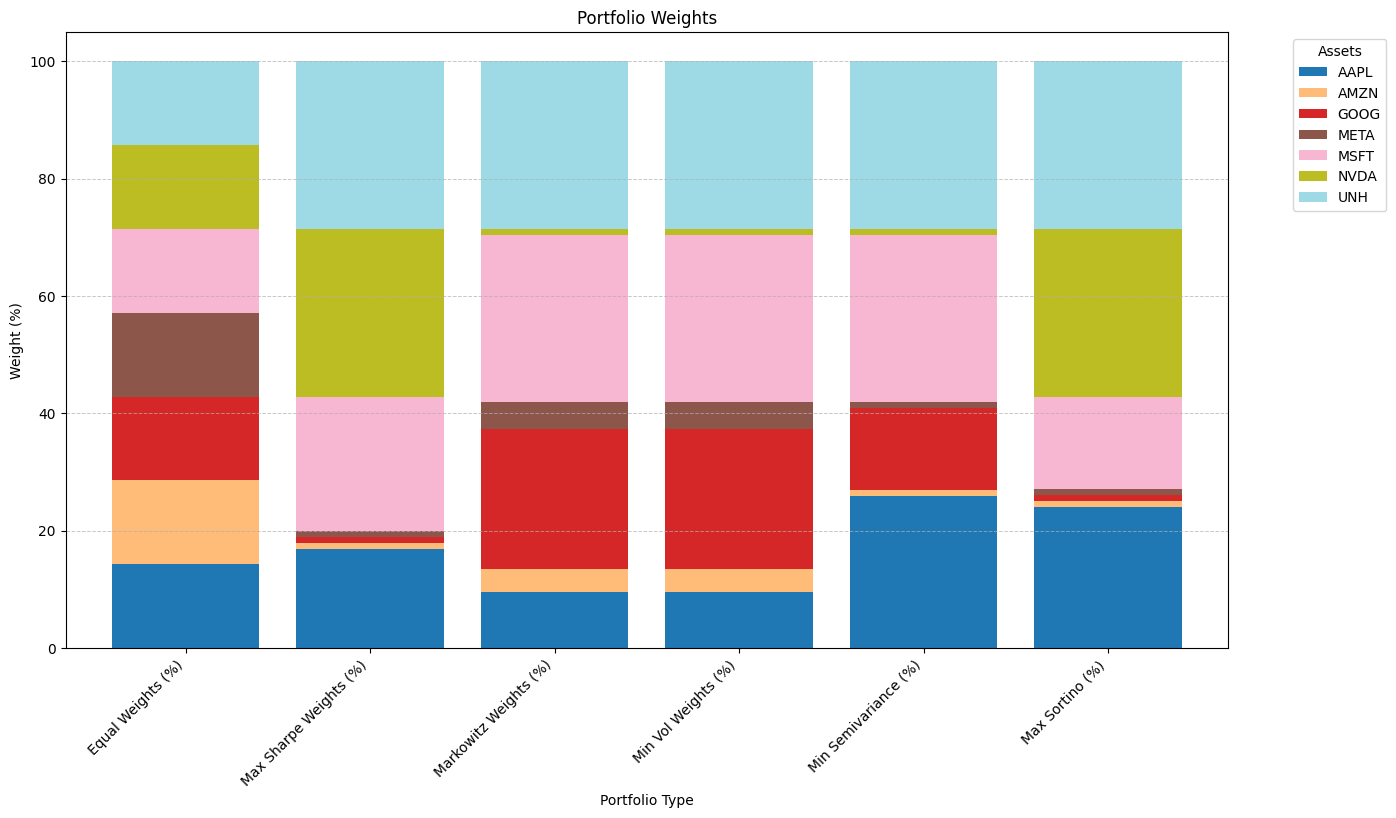

In [5]:
'''
Save data to excel: Correlation matrices, portfolio weights, monthly returns. 

'''


output_filename = 'Optimisation Output File.xlsx'
with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    
    # Write correlation matrices
    corr_sample.to_excel(writer, sheet_name='Correlation Sample')
    corr_ledoit.to_excel(writer, sheet_name='Correlation Ledoit-Wolf')
    corr_semicov.to_excel(writer, sheet_name='Correlation Semicov')

    # Format the correlations to a more readable size. 
    workbook = writer.book
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        for row in worksheet.iter_rows():
            for cell in row:
                cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        for col in range(1, worksheet.max_column + 1):
            col_letter = openpyxl.utils.get_column_letter(col)
            worksheet.column_dimensions[col_letter].width = 7.5
        for row in range(1, worksheet.max_row + 1):
            worksheet.row_dimensions[row].height = 39

        # Add conditional formatting 
        color_scale_rule = openpyxl.formatting.rule.ColorScaleRule(start_type='num', start_value=0, start_color='0000FF',
                                                                   mid_type='num', mid_value=0.5, mid_color='FFFFFF',
                                                                   end_type='num', end_value=1, end_color='FF0000')
        worksheet.conditional_formatting.add(f'A1:{openpyxl.utils.get_column_letter(worksheet.max_column)}{worksheet.max_row}', color_scale_rule)

    # Write optimised weights
    weights_df.to_excel(writer, sheet_name='Portfolio Weights')
    workbook = writer.book
    worksheet = writer.sheets['Portfolio Weights']
    for row in range(2, 2 + weights_df.shape[0]):
        for col in range(2, 2 + weights_df.shape[1]):
            cell = worksheet.cell(row=row, column=col)
            cell.number_format = '0.00%'
    for col in range(2, worksheet.max_column + 1):
        col_letter = openpyxl.utils.get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 20 

    # Write monthly security returns
    monthly_returns.to_excel(writer, sheet_name='Security Returns')
    worksheet = writer.sheets['Security Returns']
    for cell in worksheet['A']:  
        if cell.row > 1: 
            cell.number_format = 'yyyy-mm-dd'
    
print(f'Data saved to {output_filename}')

# Comparative plot of optimised portfolio weights. 
def plot_portfolio_weights(weights_df):
    # Normalise weights to sum to 100% for each portfolio type
    weights_df = weights_df.div(weights_df.sum(axis=0), axis=1) * 100
    weights_df = weights_df.T
    weights_df.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8, colormap='tab20')

    # Add titles and labels for clarity
    plt.title("Portfolio Weights")
    plt.xlabel("Portfolio Type")
    plt.ylabel("Weight (%)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Display the plot
    plt.show()

plot_portfolio_weights(weights_df)
